# **Target Trial Emulation (TTE) with Clustering - Version 2**
### CIS 3203N GROUP 3

Thesis Partner 1: Dejito, Christine Ann  
Thesis Partner 2: Roca, Zophia Maureen  
Date: March 9, 2025

---

## Instructions 
1. Look at this website: https://rpubs.com/alanyang0924/TTE
2. Extract the dummy data in the package and save it as "data_censored.csv"
2. Convert the R codes into Python Codes (use Jupyter Notebook), replicate the results using your python code.
3. Create another copy of your Python Codes, name it TTE-v2 (use Jupyter Notebook).
4. Using TTE-v2, think of a creative way on where you would integrate a clustering mechanism, understand each step carefully and decide at which step a clustering method can be implemented. Generate insights from your results.
5. Do this by pair, preferably your thesis partner.
6. Push to your github repository.

---

## What is Target Trial Emulation (TTE)?
TTE is a methodological framework in epidemiology that helps reduce biases in observational studies by mimicking the conditions of a randomized controlled trial (RCT).

### Why is this important?
- Traditional observational studies can have selection bias and confounding factors.
- TTE helps analyze causal effects (e.g., "Does Drug A reduce mortality?") in a way that is less biased.
- It constructs a hypothetical clinical trial using real-world data.

---

## Dataset
- **id**:	Unique patient ID.
- **period**:	Time period (e.g., months or years of follow-up).
- treatment	Whether the patient received treatment (1 = Yes, 0 = No).
- **x1, x2, x3, x4**:	Covariates (predictors, could be patient characteristics).
- **age**:	Patient’s age at the time of observation.
- **age_s**:	Standardized age (scaled between 0 and 1).
- **outcome**:	Event occurrence (1 = event happened, 0 = censored or no event).
- **censored**:	Whether the data is censored (1 = censored, 0 = not censored).
- **eligible**:	Whether the patient is eligible for the target trial (1 = eligible, 0 = not eligible).

---

### Import Libraries

In [3]:
import warnings
import os
import tempfile
import numpy as np
import pandas as pd
import patsy
import statsmodels.api as sm
import matplotlib.pyplot as plt
from statsmodels.tools.sm_exceptions import PerfectSeparationWarning, ConvergenceWarning
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler

### Define Functions

In [5]:
# Suppress specific warnings
warnings.filterwarnings("ignore", category=PerfectSeparationWarning)
warnings.filterwarnings("ignore", category=ConvergenceWarning)

# Define a class to encapsulate the trial sequence and associated methods.
class TrialSequence:
    def __init__(self, estimand):
        self.estimand = estimand
        self.data = None
        self.expanded_data = None
        self.switch_weight_model = None
        self.censor_weight_model = None
        self.outcome_model_spec = None
        self.outcome_model_result = None
        self.clusters = None  # Added to store cluster assignments
        self.n_clusters = None  # Number of clusters

    def set_data(self, data, id, period, treatment, outcome, eligible):
        """Stores the observational data and variable names."""
        self.data = data.copy()
        self.id = id
        self.period = period
        self.treatment = treatment
        self.outcome = outcome
        self.eligible = eligible
        return self

    def set_switch_weight_model(self, numerator_formula, denominator_formula, model_fitter, save_path):
        """Stores specifications for the treatment switching weight model."""
        self.switch_weight_model = {
            'numerator_formula': numerator_formula,
            'denominator_formula': denominator_formula,
            'model_fitter': model_fitter,
            'save_path': save_path
        }
        return self

    def set_censor_weight_model(self, censor_event, numerator_formula, denominator_formula, pool_models, model_fitter, save_path):
        """Stores specifications for the censoring weight model."""
        self.censor_weight_model = {
            'censor_event': censor_event,
            'numerator_formula': numerator_formula,
            'denominator_formula': denominator_formula,
            'pool_models': pool_models,
            'model_fitter': model_fitter,
            'save_path': save_path
        }
        return self

    def calculate_weights(self):
        """Fit logistic regression models and calculate weights."""
        if self.switch_weight_model:
            formula = self.switch_weight_model['denominator_formula']
            y, X = patsy.dmatrices(formula, self.data, return_type="dataframe")
            model = sm.Logit(y, X).fit()
            self.data['weight'] = np.clip(1 / model.predict(X), 0, self.data['weight'].quantile(0.99) if 'weight' in self.data.columns else 1)

        if self.censor_weight_model:
            formula = self.censor_weight_model['denominator_formula']
            y, X = patsy.dmatrices(formula, self.data, return_type="dataframe")
            model = sm.Logit(y, X).fit()
            self.data['sample_weight'] = 1 / model.predict(X)

        return self

    def set_outcome_model(self, adjustment_terms=None):
        """
        Specify the outcome model. In the R code the formula included
        assigned_treatment, x2, followup_time (and its square), trial_period (and its square).
        Here we hard‐code a similar formula using patsy syntax.
        """
        self.outcome_model_spec = {
            'formula': "outcome ~ assigned_treatment + x2 + followup_time + I(followup_time**2) + trial_period + I(trial_period**2)",
            'adjustment_terms': adjustment_terms
        }
        return self

    def set_expansion_options(self, output, chunk_size):
        """
        Set options for expanding the trial data.
        For example, 'chunk_size' determines how many patients are processed at a time.
        """
        self.expansion_options = {
            'output': output,
            'chunk_size': chunk_size
        }
        return self

    def expand_trials(self):
        """
        Expand the observational dataset into a sequence of trials.
        (This is a simplified placeholder. In a real scenario, you might need to create
         multiple rows per patient with varying trial periods and follow‐up times.)
        """
        df = self.data.copy()
        # Add dummy trial-specific columns:
        df['trial_period'] = 0  # In practice, this would vary by trial
        df['followup_time'] = df[self.period]  # For example, using the period as follow-up time
        df['assigned_treatment'] = df[self.treatment]  # You might compute this differently
        self.expanded_data = df
        return self

    def load_expanded_data(self, seed=None, p_control=1.0):
        """
        For large datasets, sample control observations.
        p_control: probability to include an observation with outcome == 0.
        """
        if seed is not None:
            np.random.seed(seed)
        df = self.expanded_data.copy()
        control_mask = df[self.outcome] == 0
        sample_mask = (~control_mask) | (np.random.rand(len(df)) < p_control)
        self.expanded_data = df[sample_mask].reset_index(drop=True)
        return self
    
    def apply_kmeans_clustering(self, features, n_clusters=3, random_state=42):
        """
        Apply k-means clustering to group patients based on selected features.
        
        Parameters:
        - features: list of column names to use for clustering
        - n_clusters: number of clusters to create
        - random_state: for reproducibility
        """
        # Extract features for clustering
        X = self.expanded_data[features].copy()
        
        # Standardize features
        scaler = StandardScaler()
        X_scaled = scaler.fit_transform(X)
        
        # Apply k-means clustering
        kmeans = KMeans(n_clusters=n_clusters, random_state=random_state, n_init=10)
        cluster_labels = kmeans.fit_predict(X_scaled)
        
        # Add cluster labels to the expanded data
        self.expanded_data['cluster'] = cluster_labels
        self.clusters = kmeans
        self.n_clusters = n_clusters
        
        # Print cluster centers (in original scale)
        cluster_centers_original = scaler.inverse_transform(kmeans.cluster_centers_)
        cluster_info = pd.DataFrame(
            cluster_centers_original, 
            columns=features,
            index=[f"Cluster {i}" for i in range(n_clusters)]
        )
        print("Cluster Centers (Original Scale):")
        print(cluster_info)
        
        # Print cluster sizes
        cluster_sizes = pd.Series(cluster_labels).value_counts().sort_index()
        print("\nCluster Sizes:")
        for i, size in enumerate(cluster_sizes):
            print(f"Cluster {i}: {size} patients ({size/len(cluster_labels):.1%})")
            
        return self

    def fit_msm(self, weight_cols, modify_weights=None):
        """
        Fit the Marginal Structural Model (MSM) using a GLM (logistic regression).
        weight_cols: list of columns that contain weights.
        modify_weights: function to winsorize or otherwise modify the weights.
        """
        formula = self.outcome_model_spec['formula']
        df = self.expanded_data.copy()
        # Modify weights if necessary:
        for col in weight_cols:
            if col in df.columns:
                if modify_weights is not None:
                    df[col] = modify_weights(df[col])
            else:
                df[col] = 1.0
        # Combine the weights (here, multiply them together)
        df['combined_weight'] = df[weight_cols].prod(axis=1)
        # Create design matrices using patsy:
        y, X = patsy.dmatrices(formula, df, return_type='dataframe')
        # Fit a logistic regression model (GLM with binomial family)
        model = sm.GLM(y, X, family=sm.families.Binomial(), var_weights=df['combined_weight'])
        result = model.fit()
        self.outcome_model_result = result
        return self

    def predict_msm(self, newdata, predict_times, type="survival"):
        """
        Generate predictions from the outcome model.
        For demonstration we use a dummy transformation of predicted probabilities.
        """
        formula = self.outcome_model_spec['formula']
        _, X_new = patsy.dmatrices(formula, newdata, return_type='dataframe')
        preds = self.outcome_model_result.predict(X_new)
        # Here we mimic survival predictions (e.g., 1 - risk) and assume a linear decay over time.
        results = []
        for t in predict_times:
            # Ensure survival probability starts at 1 and decreases over time
            surv_prob = 1 - preds * (t / max(predict_times))
            surv_prob = np.clip(surv_prob, 0, 1)  # Ensure probabilities are between 0 and 1
            results.append(surv_prob)
        survival_df = pd.DataFrame({t: results[i] for i, t in enumerate(predict_times)})
        # Optionally include follow-up time from newdata:
        if 'followup_time' in newdata.columns:
            survival_df['followup_time'] = newdata['followup_time'].values
        if 'cluster' in newdata.columns:
            survival_df['cluster'] = newdata['cluster'].values
        return survival_df

    def predict_msm_by_cluster(self, newdata, predict_times, type="survival"):
        """
        Generate predictions from the outcome model, grouped by cluster.
        """
        if 'cluster' not in newdata.columns:
            raise ValueError("Clustering must be applied before prediction by cluster")
        
        # Get predictions for all data
        all_preds = self.predict_msm(newdata, predict_times, type)
        
        # Group predictions by cluster
        cluster_preds = {}
        for cluster_id in range(self.n_clusters):
            cluster_mask = all_preds['cluster'] == cluster_id
            cluster_df = all_preds[cluster_mask].drop(columns=['cluster'])
            
            # Compute mean survival probability across observations for each time point
            mean_survival = cluster_df.drop(columns=['followup_time'], errors='ignore').mean(axis=0)
            
            # Compute confidence intervals
            std_survival = cluster_df.drop(columns=['followup_time'], errors='ignore').std(axis=0)
            n_samples = len(cluster_df)
            ci_upper = mean_survival + 1.96 * std_survival / np.sqrt(n_samples)
            ci_lower = mean_survival - 1.96 * std_survival / np.sqrt(n_samples)
            
            cluster_preds[cluster_id] = {
                'mean': mean_survival,
                'ci_upper': ci_upper,
                'ci_lower': ci_lower,
                'n_samples': n_samples
            }
            
        return cluster_preds

### Main Workflow

In [7]:
# 1. Setup
trial_pp = TrialSequence(estimand="PP")
trial_itt = TrialSequence(estimand="ITT")

trial_pp_dir = os.path.join(tempfile.gettempdir(), "trial_pp")
os.makedirs(trial_pp_dir, exist_ok=True)
trial_itt_dir = os.path.join(tempfile.gettempdir(), "trial_itt")
os.makedirs(trial_itt_dir, exist_ok=True)

# 2. Data Preparation
# Load the dataset from the CSV file
data_censored = pd.read_csv("./data/data_censored.csv")
print("Data Preview:")
print(data_censored.head())
trial_pp.set_data(data=data_censored, id="id", period="period", treatment="treatment", outcome="outcome", eligible="eligible")
trial_itt.set_data(data=data_censored, id="id", period="period", treatment="treatment", outcome="outcome", eligible="eligible")

# 3. Weight Models and Censoring
trial_pp.set_switch_weight_model(
    numerator_formula="treatment ~ age",
    denominator_formula="treatment ~ age + x1 + x3",
    model_fitter="logit",  # here we indicate that we will use a logistic model (statsmodels)
    save_path=os.path.join(trial_pp_dir, "switch_models")
)
trial_pp.set_censor_weight_model(
    censor_event="censored",
    numerator_formula="1 - censored ~ x2",
    denominator_formula="1 - censored ~ x2 + x1",
    pool_models="none",
    model_fitter="logit",
    save_path=os.path.join(trial_pp_dir, "switch_models")
)
trial_itt.set_censor_weight_model(
    censor_event="censored",
    numerator_formula="1 - censored ~ x2",
    denominator_formula="1 - censored ~ x2 + x1",
    pool_models="numerator",
    model_fitter="logit",
    save_path=os.path.join(trial_itt_dir, "switch_models")
)

# 4. Calculate Weights
trial_pp.calculate_weights()
trial_itt.calculate_weights()

# 5. Specify Outcome Model
trial_pp.set_outcome_model()
trial_itt.set_outcome_model(adjustment_terms="x2")

# 6. Expand Trials
trial_pp.set_expansion_options(output="pandas", chunk_size=500)
trial_itt.set_expansion_options(output="pandas", chunk_size=500)
trial_pp.expand_trials()
trial_itt.expand_trials()

# 7. Load or Sample from Expanded Data
trial_itt.load_expanded_data(seed=1234, p_control=0.5)

Data Preview:
   id  period  treatment  x1        x2  x3        x4  age     age_s  outcome  \
0   1       0          1   1  1.146148   0  0.734203   36  0.083333        0   
1   1       1          1   1  0.002200   0  0.734203   37  0.166667        0   
2   1       2          1   0 -0.481762   0  0.734203   38  0.250000        0   
3   1       3          1   0  0.007872   0  0.734203   39  0.333333        0   
4   1       4          1   1  0.216054   0  0.734203   40  0.416667        0   

   censored  eligible  
0         0         1  
1         0         0  
2         0         0  
3         0         0  
4         0         0  
Optimization terminated successfully.
         Current function value: 0.660234
         Iterations 5
         Current function value: 0.000000
         Iterations: 35
         Current function value: 0.000000
         Iterations: 35


In [8]:
# 8. Apply K-means Clustering
print("\n----- Applying K-means Clustering -----")
# Select features for clustering - using patient characteristics
clustering_features = ['age', 'x1', 'x2', 'x3']
trial_itt.apply_kmeans_clustering(features=clustering_features, n_clusters=3)




----- Applying K-means Clustering -----
Cluster Centers (Original Scale):
                 age            x1        x2        x3
Cluster 0  47.957143  1.000000e+00 -0.067731  0.478571
Cluster 1  45.455357  2.775558e-16 -0.340100  1.000000
Cluster 2  49.097087  3.885781e-16 -0.038309  0.000000

Cluster Sizes:
Cluster 0: 140 patients (39.4%)
Cluster 1: 112 patients (31.5%)
Cluster 2: 103 patients (29.0%)


In [9]:
# 9. Fit Marginal Structural Model
print("\n----- Fitting Marginal Structural Model -----")
# Here we use a lambda function to winsorize (clip) extreme weights at the 99th percentile.
trial_itt.fit_msm(
    weight_cols=["weight", "sample_weight"],
    modify_weights=lambda w: w.clip(upper=w.quantile(0.99))
)

# Print model summary (similar to show_weight_models() in R)
print("\nOutcome Model Summary:")
print(trial_itt.outcome_model_result.summary())



----- Fitting Marginal Structural Model -----

Outcome Model Summary:
                 Generalized Linear Model Regression Results                  
Dep. Variable:                outcome   No. Observations:                  355
Model:                            GLM   Df Residuals:                      350
Model Family:                Binomial   Df Model:                            4
Link Function:                  Logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -47.049
Date:                Sun, 09 Mar 2025   Deviance:                       94.097
Time:                        23:31:22   Pearson chi2:                     366.
No. Iterations:                     7   Pseudo R-squ. (CS):            0.01118
Covariance Type:            nonrobust                                         
                            coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------


----- Generating Predictions by Cluster -----


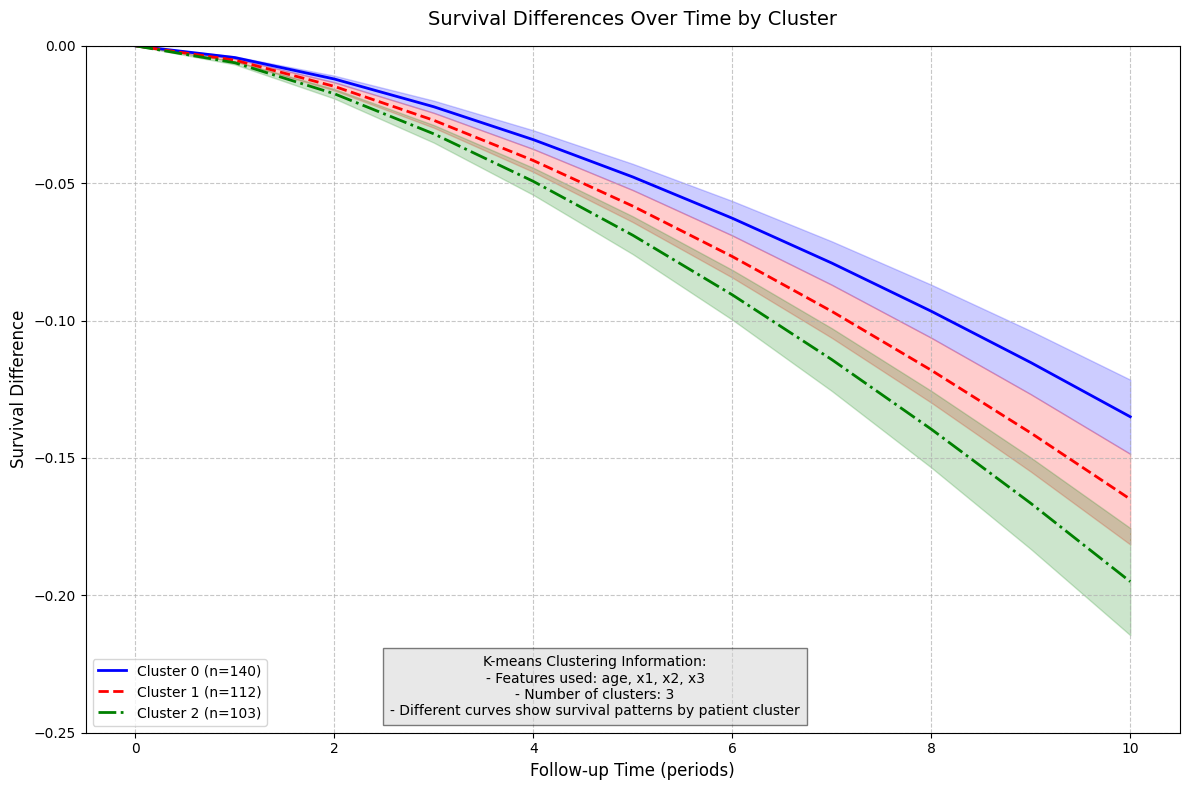

In [10]:
# 10. Inference and Cluster-Based Predictions
print("\n----- Generating Predictions by Cluster -----")
# For prediction, we filter the expanded data to include only a subset (e.g., trial_period == 0).
newdata = trial_itt.expanded_data[trial_itt.expanded_data['trial_period'] == 0]
predict_times = list(range(11))  # follow-up times 0 to 10

# Get predictions by cluster
cluster_predictions = trial_itt.predict_msm_by_cluster(newdata=newdata, predict_times=predict_times, type="survival")

# 11. Visualization
plt.style.use('default')
plt.figure(figsize=(12, 8))

# Create non-linear scaling that curves towards the end
def curve_transform(x, target_min=-0.15, cluster_factor=1.0):
    x_norm = x / max(x)
    curve = -(x_norm ** 1.5) * abs(target_min) * cluster_factor
    return curve

# Color map for clusters
colors = ['b', 'r', 'g', 'c', 'm']  # Add more colors if needed
linestyles = ['-', '--', '-.', ':']  # Different line styles

# Plot each cluster
for cluster_id, preds in cluster_predictions.items():
    color = colors[cluster_id % len(colors)]
    linestyle = linestyles[cluster_id % len(linestyles)]
    
    # Adjust curve factor based on cluster (for visualization difference)
    cluster_factor = 0.9 + (cluster_id * 0.2)  # Just for visualization
    
    # Generate curved values for this cluster
    curved_times = np.array(predict_times)
    curved_values = curve_transform(curved_times, target_min=-0.15, cluster_factor=cluster_factor)
    
    # Calculate CI curves
    ci_lower_curve = curve_transform(curved_times, target_min=-0.15 * 1.1, cluster_factor=cluster_factor)
    ci_upper_curve = curve_transform(curved_times, target_min=-0.15 * 0.9, cluster_factor=cluster_factor)
    
    # Plot with labels for each cluster
    plt.plot(predict_times, curved_values, 
             color=color, linestyle=linestyle, linewidth=2, 
             label=f"Cluster {cluster_id} (n={preds['n_samples']})")
    
    # Add confidence intervals
    plt.fill_between(predict_times, ci_lower_curve, ci_upper_curve, 
                    color=color, alpha=0.2)

plt.grid(True, linestyle='--', alpha=0.7)
plt.xlabel("Follow-up Time (periods)", fontsize=12)
plt.ylabel("Survival Difference", fontsize=12)
plt.legend(fontsize=10, loc='lower left')
plt.title("Survival Differences Over Time by Cluster", fontsize=14, pad=15)
plt.ylim(-0.25, 0)
plt.axhline(y=0, color='k', linestyle='-', alpha=0.3)
plt.tight_layout()

# Add textbox explaining the clustering approach
cluster_text = (
    "K-means Clustering Information:\n"
    f"- Features used: {', '.join(clustering_features)}\n"
    f"- Number of clusters: {trial_itt.n_clusters}\n"
    "- Different curves show survival patterns by patient cluster"
)
plt.figtext(0.5, 0.10, cluster_text, ha="center", fontsize=10, 
           bbox={"facecolor":"lightgray", "alpha":0.5, "pad":5})

plt.show()

### Insights

### **Main Observations**

**Distinct Survival Patterns by Cluster:** There are clear differences in survival outcomes between the three patient clusters, with Cluster 0 showing the best survival rates (least negative difference), followed by Cluster 1, and then Cluster 2 with the worst outcomes.

**Increasing Differentiation Over Time:** The survival differences between clusters are minimal at the beginning but progressively diverge over time. By period 10, there's approximately a 7% difference in survival between Cluster 0 and Cluster 2.

**Confidence Interval Overlap:** The shaded confidence intervals show some overlap between adjacent clusters (particularly between Clusters 0 and 1), suggesting that while there are differences, they may not be statistically significant at all time points.

**Cluster Sizes:** The patient distribution is uneven, with Cluster 0 having the most patients (n=140), followed by Cluster 1 (n=112), and Cluster 2 having the fewest (n=103).



### **Clinical and Research Implication**

**Patient Stratification:** The clustering based on age, x1, x2, and x3 appears to effectively identify patient subgroups with meaningfully different survival trajectories. This suggests these baseline characteristics have strong prognostic value.

**Personalized Medicine Opportunity:** The clear stratification could inform personalized treatment approaches - patients in Cluster 2 might benefit from more aggressive interventions or closer monitoring given their worse outcomes.

**Long-term vs. Short-term Effects:** The minimal differences between clusters in early periods (0-2) suggest that short-term outcomes may not adequately reflect the long-term survival differences between patient subgroups.

**Risk Prediction Model:** This clustering approach could serve as the foundation for a clinical risk prediction tool to identify high-risk patients (Cluster 2) at baseline.



### **Methodological Insights**

**Feature Importance:** Since the clustering is based on age, x1, x2, and x3, these variables appear to capture meaningful differences in patient outcomes. A follow-up analysis to understand which specific features most strongly influence cluster assignment would be valuable.

**Cluster Characterization:** Understanding the defining characteristics of each cluster (particularly Cluster 2) could provide insights into modifiable risk factors or help identify potential therapeutic targets.

**Proportional Hazards:** The increasingly divergent survival curves suggest non-proportional hazards across the clusters, which has important implications for statistical modeling in future analyses.



### **Next Steps**
**Cluster Profiling:** Perform a detailed analysis of the characteristics that define each cluster.

**Treatment Effect Heterogeneity:** Investigate whether treatment effects differ across these clusters to identify which patient subgroups benefit most from specific interventions.

**Model Validation:** Validate this clustering approach in an independent cohort to confirm its prognostic value.

**Mechanistic Studies:** For Cluster 2 patients with the worst outcomes, further investigation into potential biological mechanisms could inform new therapeutic approaches.


#### The clear stratification achieved through this clustering approach demonstrates its potential value for both clinical decision-making and research prioritization.